In [1]:
import scipy.io as sio
import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import pandas as pd
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from pathlib import Path
import seaborn as sns
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel
import glob
import matplotlib.patches as patches

# SET PATHS:
baseDir = '/Users/alighavampour/Desktop/Projects/bimanual_wrist/data/fMRI'
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'


In [25]:
sn = 8
glm = 3
region_labels = [1, 2, 3, 4, 5, 6, 7, 8]
region_names = ['S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', 'SPLp']

#  Define atlas map
white = os.path.join(baseDir, surfacewbDir, f's{sn:02d}', f's{sn:02d}.L.white.32k.surf.gii') # Individual white surface
pial = os.path.join(baseDir, surfacewbDir, f's{sn:02d}', f's{sn:02d}.L.pial.32k.surf.gii') # Invividual pial surface
mask = os.path.join(baseDir, f'glm{glm}', f's{sn:02d}', 'mask.nii') # Mask in functional space for that subject

# File names for data extraction
nii_names = sorted(glob.glob(os.path.join(baseDir, f'glm{glm}', f's{sn:02d}', "beta_*.nii")))
nii_names = nii_names[0:480] # remove the run constant regressors
resMS_name = [os.path.join(baseDir, f'glm{glm}', f's{sn:02d}', 'ResMS.nii')]
spmT_names = glob.glob(os.path.join(baseDir, f'glm{glm}', f's{sn:02d}', "spmT*.nii"))

beta = []
resMS = []
beta_white = []
spmT = []
for i, r in enumerate(region_labels):
    print(f'Extracting region {region_names[i]} ({r})')
    atlas,_ = am.get_atlas('fs32k')
    atlas_left = atlas.get_hemisphere(0)
    subatlas = atlas_left.get_subatlas_image(os.path.join(atlasDir,'ROI.32k.L.label.gii'), value=r)
    amap = am.AtlasMapSurf(subatlas.vertex[0],white,pial,mask) # Atlas map
    # Compute the voxels in native space
    amap.build()

    # save the ROI mask in native space for checking purposes
    amap.save_as_image(os.path.join(baseDir, regDir, f's{sn:02d}', f'amap_ROI_{sn:02d}_glm{glm}_{region_names[i]}.nii'))
    
    # This extract all the relevant voxels in native space (use for RSA)
    beta.append(amap.extract_data_native(nii_names))
    resMS.append(amap.extract_data_native(resMS_name))
    beta_white.append(beta[i]/np.sqrt(resMS[i]))
    spmT.append(amap.extract_data_native(spmT_names))

regressor_info = pd.read_table(os.path.join(baseDir, f'glm{glm}', f's{sn:02d}', 'reginfo.tsv'))


Extracting region S1 (1)
Extracting region M1 (2)
Extracting region PMd (3)
Extracting region PMv (4)
Extracting region SMA (5)
Extracting region V1 (6)
Extracting region SPLa (7)
Extracting region SPLp (8)


In [26]:
conds = regressor_info['name'].values.flatten()
# conds_shortened = [s.split(":")[1].split(",")[0] + "_r" + s.split(":")[2] for s in conds]
# conds_chords_only = [s.split(":")[1].split(",")[0] for s in conds]

# conds = np.array(conds_chords_only)
# conds = np.array(conds_shortened)

# Estimate and plot the second moment matrices
n_cond = len(np.unique(conds))
G_hat = np.zeros((len(region_labels), n_cond, n_cond))
D = np.zeros((len(region_labels), n_cond, n_cond))
for i, r in enumerate(region_labels):
    Y = beta_white[i]

    # remove nan voxels:
    cols_with_nan = np.isnan(Y).any(axis=0)  # Boolean array, True where columns have NaN
    # Get columns without NaN values
    cols_without_nan = ~cols_with_nan  # Invert the boolean mask
    # Create new array with only the non-NaN columns
    Y = Y[:, cols_without_nan]

    partition_vec = regressor_info['run'].values.flatten()
    cond_vec = conds.flatten()
    
    G_hat[i,:,:],_ = pcm.est_G_crossval(Y,
                                        cond_vec,
                                        partition_vec,
                                        X=pcm.matrix.indicator(partition_vec))
    D[i,:,:] = np.sign(pcm.G_to_dist(G_hat[i,:,:])) * np.sqrt(np.abs(pcm.G_to_dist(G_hat[i,:,:])))
    
    neg_count_region = np.sum(D[i,:,:] < 0)
    total_region = D[i].size
    neg_percentage_region = (neg_count_region / total_region) * 100
    print(f"{region_names[i]} negative distances = ({neg_percentage_region:.2f}%)")

S1 negative distances = (15.97%)
M1 negative distances = (20.14%)
PMd negative distances = (19.18%)
PMv negative distances = (25.00%)
SMA negative distances = (29.51%)
V1 negative distances = (4.34%)
SPLa negative distances = (22.57%)
SPLp negative distances = (27.34%)


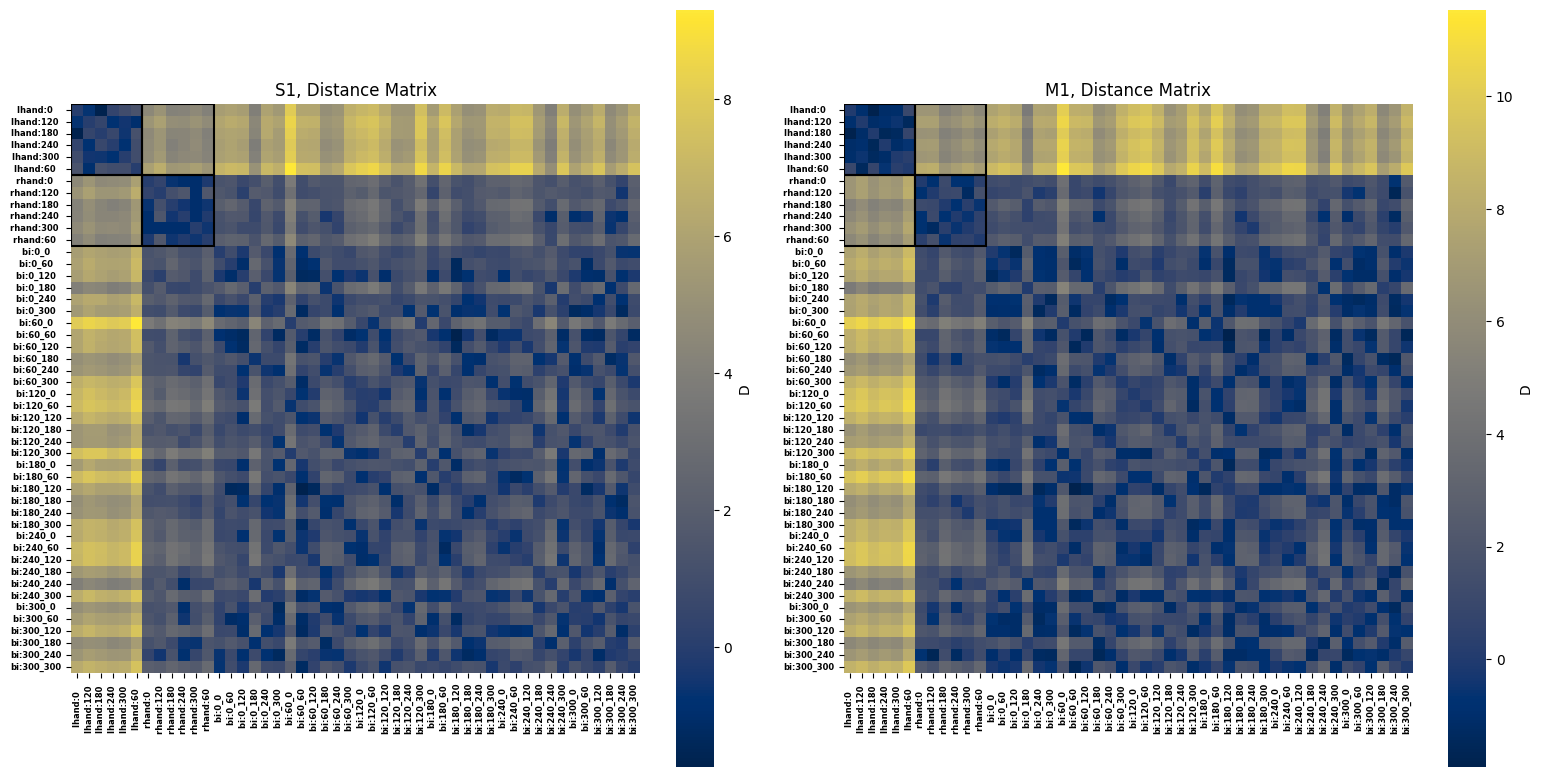

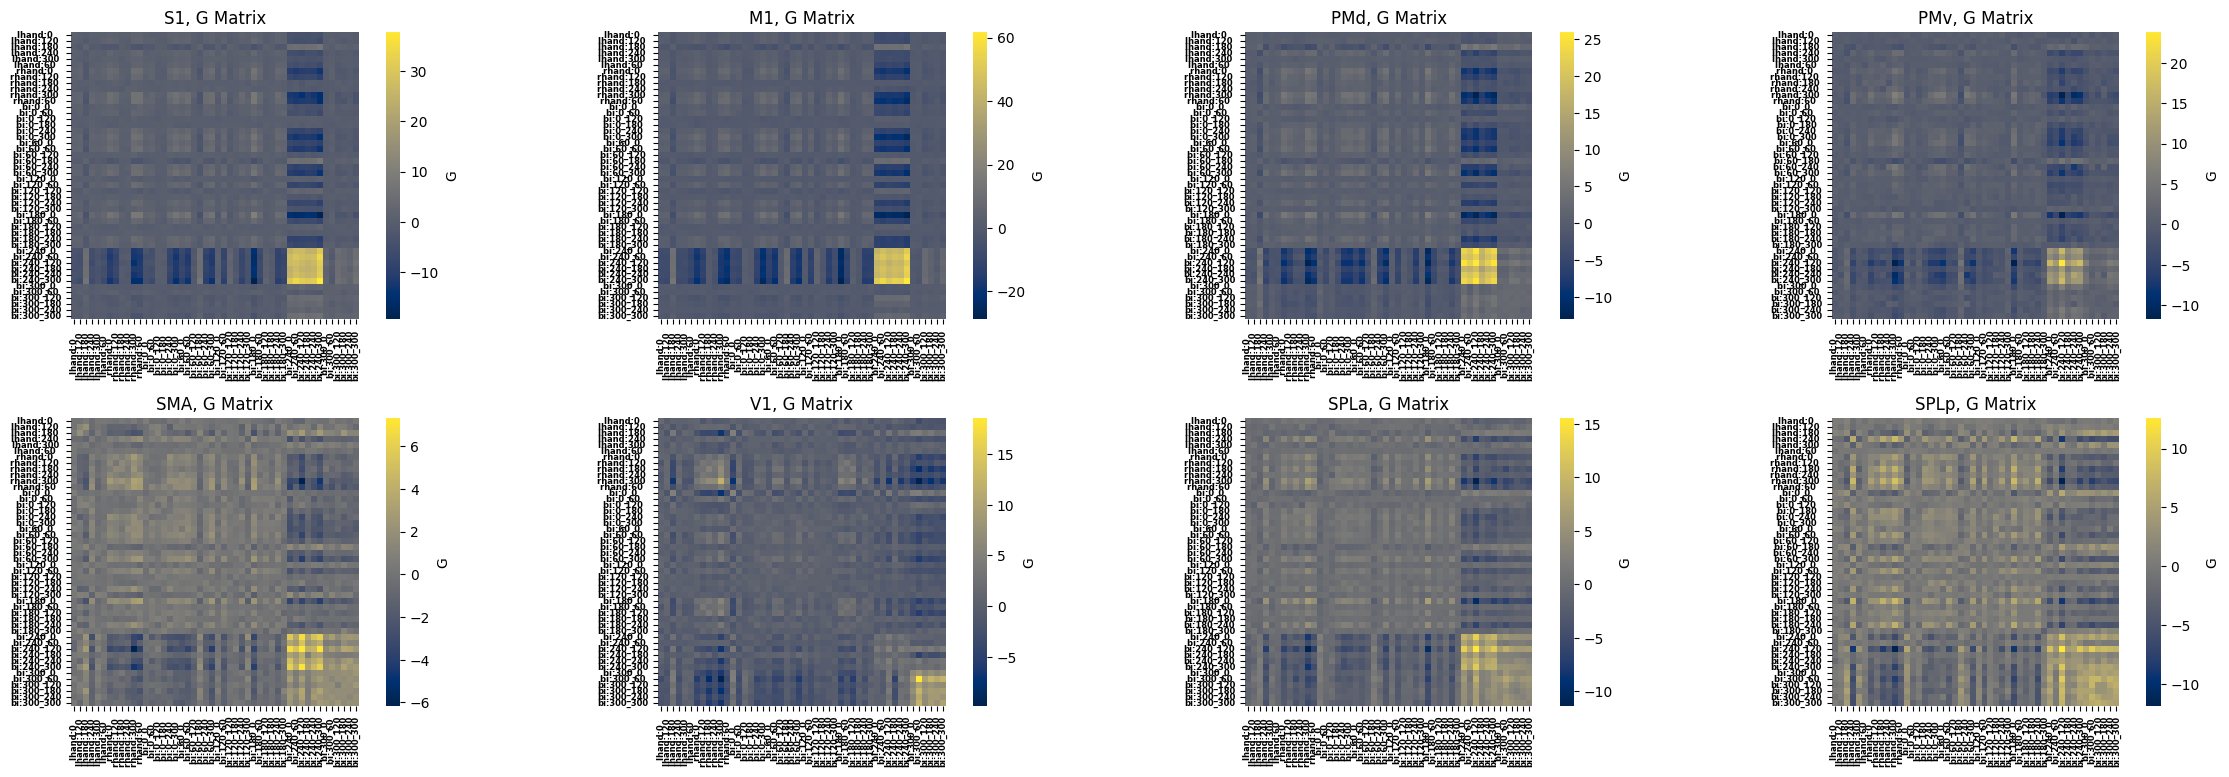

In [27]:
conditions = np.unique(conds)
custom_order = np.array(['lhand:0   ', 'lhand:120 ', 'lhand:180 ', 'lhand:240 ', 'lhand:300 ', 'lhand:60  ',
                         'rhand:0   ', 'rhand:120 ', 'rhand:180 ', 'rhand:240 ', 'rhand:300 ', 'rhand:60  ',
                         'bi:0_0    ', 'bi:0_60   ', 'bi:0_120  ', 'bi:0_180  ', 'bi:0_240  ', 'bi:0_300  ',
                         'bi:60_0   ', 'bi:60_60  ', 'bi:60_120 ', 'bi:60_180 ', 'bi:60_240 ', 'bi:60_300 ',
                         'bi:120_0  ', 'bi:120_60 ', 'bi:120_120', 'bi:120_180', 'bi:120_240', 'bi:120_300',
                         'bi:180_0  ', 'bi:180_60 ', 'bi:180_120', 'bi:180_180', 'bi:180_240', 'bi:180_300',
                         'bi:240_0  ', 'bi:240_60 ', 'bi:240_120', 'bi:240_180', 'bi:240_240', 'bi:240_300',
                         'bi:300_0  ', 'bi:300_60 ', 'bi:300_120', 'bi:300_180', 'bi:300_240', 'bi:300_300', 
                         ])
# custom_order = conditions

# Create a mapping of values to their rank in the custom order
order_map = {val: idx for idx, val in enumerate(custom_order)}
# Get sorting indices based on the custom order
sort_indices = np.argsort([order_map[val] for val in conditions])

# Squares to plot (x, y, width, height)
squares = [
    (0, 0, 6, 6), 
    (6, 6, 6, 6),
    # (18, 18, 8, 8),

    (6, 0, 6, 6),
    # (18, 0, 8, 6),
    
    (0, 6, 6, 6),
    # (0, 18, 6, 8)
]

cm = 1/2.54  # centimeters in inches
# plot the second moment matrices:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(40*cm, 20*cm))
for i, ax in enumerate(axes.flat):
    # Apply sorting to the data
    sorted_D = D[i]
    sorted_D = sorted_D[np.ix_(sort_indices, sort_indices)] # sorted_D[sort_indices][:, sort_indices]
    sns.heatmap(sorted_D, square=True, cbar_kws={'label': 'D'}, cmap='cividis', ax=ax)
    ax.set_title(f'{region_names[i]}, Distance Matrix')
    
    # Overlay squares
    for x, y, w, h in squares:
        rect = patches.Rectangle((x, y), w, h, linewidth=1.5, edgecolor='black', facecolor='none')
        ax.add_patch(rect)

    # sort based on num fingers:
    # Set labels manually with more formatting options
    ax.set_xticks(np.arange(0,n_cond)+0.5)
    ax.set_xticklabels(custom_order, rotation=90, fontsize=6, fontweight='bold')
    ax.set_yticks(np.arange(0,n_cond)+0.5)
    ax.set_yticklabels(custom_order, rotation=0, fontsize=6, fontweight='bold')
    
plt.tight_layout()
plt.savefig(os.path.join('./figures',f'bmw_D_s{sn:02d}_glm{glm}_ses.pdf'), format='pdf', bbox_inches='tight')
plt.show()

cm = 1/2.54  # centimeters in inches
# plot the second moment matrices:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(60*cm, 20*cm))
for i, ax in enumerate(axes.flat):
    # Apply sorting to the data
    sorted_G = G_hat[i]
    sorted_D = sorted_G[np.ix_(sort_indices, sort_indices)]
    sns.heatmap(sorted_G, cmap='cividis', square=True, cbar_kws={'label': 'G'}, ax=ax)
    ax.set_title(f'{region_names[i]}, G Matrix')
    
    # Overlay squares
    # for x, y, w, h in squares:
    #     rect = patches.Rectangle((x, y), w, h, linewidth=1.5, edgecolor='black', facecolor='none')
    #     ax.add_patch(rect)

    # sort based on num fingers:
    # Set labels manually with more formatting options
    ax.set_xticks(np.arange(0,n_cond)+0.5)
    ax.set_xticklabels(custom_order, rotation=90, fontsize=6, fontweight='bold')
    ax.set_yticks(np.arange(0,n_cond)+0.5)
    ax.set_yticklabels(custom_order, rotation=0, fontsize=6, fontweight='bold')
    
plt.tight_layout()
plt.savefig(os.path.join('./figures',f'bmw_G_s{sn:02d}_glm{glm}.pdf'), format='pdf', bbox_inches='tight')
plt.show()